In [ ]:
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np 
import pickle

### Internal classes
from loaders import ItemLoader
from items import Item 

In [ ]:
%matplotlib inline

In [ ]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN_KEY = os.getenv("HF_TOKEN")

In [ ]:
login(HF_TOKEN_KEY, add_to_git_credential=True)

In [ ]:
items = ItemLoader("Electronics").load()

print(items[0].prompt)

print(len(items))

## Scale Up -- All Different Categories Into One List

In [ ]:
dataset_names = [
    "All_Beauty", "Arts_Crafts_and_Sewing", "Cell_Phones_and_Accessories", 
    "Electronics", "Gift_Cards", "Handmade_Products", "Industrial_and_Scientific", 
    "Musical_Instruments", "Toys_and_Games"
]

In [ ]:
items = [] 
for dataset_name in dataset_names: 
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

In [ ]:
print(f"Grand Total of {len(items):,} Items.")

In [ ]:
### Count tokens -- Avr and highest out of the all items 
tokens = [item.token_count for item in items]

plt.figure(figsize=(15, 6))
plt.title(f"Avr Tokens: {sum(tokens) / len(tokens):.2f} | Highest Tokens: {max(tokens)}")
plt.xlabel("Tokens")
plt.ylabel("Counts")
plt.hist(tokens, rwidth=0.7, color="purple", bins = range(150, 200, 10))
plt.show()

In [ ]:
### Price distribution out of the all items
### (Avr price and highest)

prices = [item.price for item in items]

plt.figure(figsize=(15, 6))
plt.title(f"Avr Price: \\${sum(prices) / len(prices):,.2f} | Highest Price: ${max(prices):,}")
plt.xlabel("Price")
plt.ylabel("Counts")
plt.hist(prices, rwidth=0.7, color="C8", bins=range(0, 1000, 10))
plt.show()

In [ ]:
print(items[1])

In [ ]:
raw_categories = [item.category for item in items]

counter = Counter(raw_categories)

### Category with the highest number of items
top_category = counter.most_common(1)

### keys and values - keys: categories | values: item counts
# key_list = [k for k, v in counter.items()]
# value_list = [v for k, v in counter.items()]

categories, counts = zip(*counter.items())

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title(f"Avr Num of Items: {round(counter.total() / len(categories))} | Highest Products Listed: {top_category[0][0]} - {top_category[0][1]} items")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation=10, ha="right")
plt.show()

In [ ]:
print(items[0])

## Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [ ]:
slots = defaultdict(list)
for item in items: 
    slots[round(item.price)].append(item)


In [ ]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)

### samples list with data sorted by lower price to higher order: range(1, 1000)
samples = []

for i in range(1, 1000): 
    slot = slots[i]
    if i >= 240:
        samples.extend(slot) 
    elif len(slot) <= 1200: 
        samples.extend(slot) 
    else: 
        weights = np.array([1 if item.category == "Electronics" else 5 for item in slot])
        weights = weights / sum(weights) 
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights) 
        selected = [slot[i] for i in selected_indices]
        samples.extend(selected)
        
print(f"There are {len(samples):,} items in the sample")
        

In [ ]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in samples]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
### Category Counter 

categories = [item.category for item in samples]

category_counter = Counter(categories) 

### Separate categories and counts 
cats, counts = zip(*category_counter.items())
### Category with the highest counts
highest_key = category_counter.most_common(1)

### Bar Chart:
plt.figure(figsize=(15, 6))
plt.bar(cats, counts, color="lightgreen")
plt.title(f"Avr Counts of Categories: {sum(counts) / len(counts):.2f} | Highest Counts: {max(counts)}({highest_key[0][0]})")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation=30, ha="right")


### Add labels on top of each bar 
for i, v in enumerate(counts): 
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

plt.show()


In [ ]:
### Pie chart

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=cats, autopct='%1.0f%%', startangle=90)

### Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

### Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

In [ ]:
### Correlation between text verbosity and price 

### To Check:
### if high-end products having longer, more detailed descriptions 
### or cheap products having short, minimal text.


sizes = [len(item.prompt) for item in samples]
prices = [item.price for item in samples] 

plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

plt.title("Is there a simple correlation?")
plt.xlabel("Text Length")
plt.ylabel("Price")

plt.show()

In [ ]:
def report(item): 
    prompt = item.prompt 
    tokens = Item.tokenizer.encode(item.prompt)
    print("PROMPT:\n", prompt)
    print("\n")
    ### Check the last 10 tokens and text to check tokenizer correctly includes the target prompt 
    print("Last 10 Tokens:\n",tokens[-10:])
    print("\n")
    print("Last 10 Decoded:\n",Item.tokenizer.batch_decode(tokens[-10:]))

print(report(samples[222382]))

In [ ]:
random.seed(42)
random.shuffle(samples)

print(len(samples))
### Use 5% - 10% of the whole data for testing purposes
train = samples[:230_000]
test = samples[230_000:246_000]

print(f"Length of Train Data: {len(train)}\nLength of Test Data: {len(test)}")

In [ ]:
print(train[0].prompt)

In [ ]:
print(test[0].test_prompt())

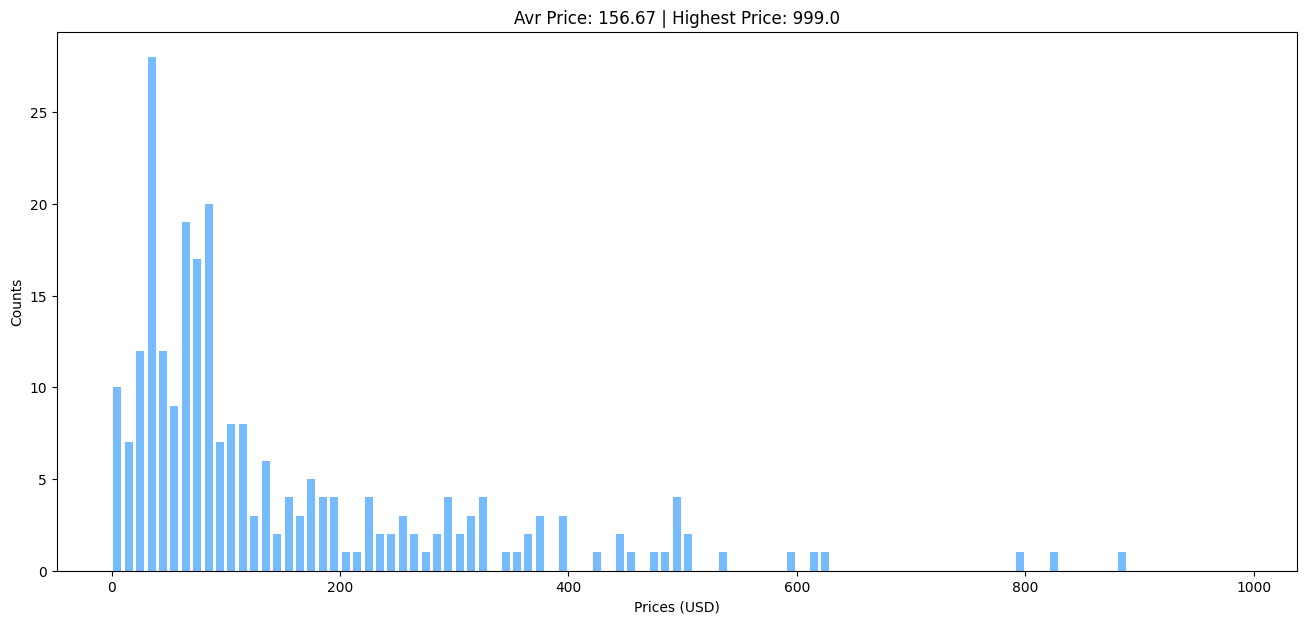

In [38]:
# Plot the distribution of prices in the first 250 test points

prices = [item.price for item in test[:250]]

plt.figure(figsize=(16, 7))
plt.title(f"Avr Price: {sum(prices) / len(prices):.2f} | Highest Price: {max(prices)}")
plt.xlabel("Prices (USD)")
plt.ylabel("Counts")
plt.hist(prices, rwidth=0.7, color="xkcd:sky blue", bins=range(0, 1000, 10))
plt.show()

## Upload Dataset

In [40]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.prompt for item in test]
test_prices = [item.price for item in test]

[189.99, 64.45, 128.99, 252.7, 16.99, 499.99, 363.36, 24.75, 65.2, 189.95]


In [42]:
### Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})

dataset = DatasetDict({
    "train": train_dataset, 
    "test": test_dataset
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'price'],
        num_rows: 230000
    })
    test: Dataset({
        features: ['text', 'price'],
        num_rows: 16000
    })
})


In [44]:
### Push to HF Hub

HF_USER = "MightyOctopus"
DATASET_NAME = f"{HF_USER}/amazon-pricer-dataset"

dataset.push_to_hub(DATASET_NAME, private=False)


Creating parquet from Arrow format: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  3.20ba/s]
Processing Files (0 / 0): |                                                 |  0.00B /  0.00B            
Processing Files (0 / 1):   1%|▏                                            |  524kB /  103MB,  328kB/s  
Processing Files (0 / 1):   2%|▋                                            | 1.58MB /  103MB,  716kB/s  
Processing Files (0 / 1):   2%|▉                                            | 2.10MB /  103MB,  875kB/s  
Processing Files (0 / 1):   3%|█▍                                           | 3.15MB /  103MB, 1.21MB/s  
Processing Files (0 / 1):   6%|██▊                                          | 6.30MB /  103MB, 2.25MB/s  
Processing Files (0 / 1):  10%|████▌                                        | 10.5MB /  103MB, 3.50MB/s  
Processing Files (0 / 1):  15%|██████▋                                      | 15.2MB /  103MB, 4.76MB/s  
Processing Files (0 / 1):  22%|█████████▊     

CommitInfo(commit_url='https://huggingface.co/datasets/MightyOctopus/amazon-pricer-dataset/commit/8cca4383996e320e290ba6eeb18bbf5595986559', commit_message='Upload dataset', commit_description='', oid='8cca4383996e320e290ba6eeb18bbf5595986559', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MightyOctopus/amazon-pricer-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MightyOctopus/amazon-pricer-dataset'), pr_revision=None, pr_num=None)

In [45]:
with open("train.pkl", "wb") as f: 
    pickle.dump(train, f)

with open("test.pkl", "wb") as f: 
    pickle.dump(test, f)